<font color = "red">Note: This is currently work in progress, with current issues to be addressed and further work listed at the end.</font>

# Food Groups
Can we pick out traditional 'food groups' (akin to the old food pyramid) or perhaps come up with new food groups via the use of clustering methods based on the nutrition breakdown of different food items?
<body>
<figure>
  <img src="https://upload.wikimedia.org/wikipedia/commons/6/6d/USDA_Food_Pyramid.gif", alt = "A Food Pyramid">
  <center><figcaption>An example of the food pyramid</figcaption></center>
</figure>

While the food pyramid as a tool has been criticised for being misleading or inaccurate, the idea of separating foods into different categories based on their 'nutritional value' is still common place and the basis of many diets.<br>

A fairly rich dataset for this is available at http://openfoodfacts.org/ which contains information on products from a number of places around the world (72046 products sold in 135 different countries). From this we'll attempt to find what products are similar in terms of their nutritional content and would potentially be interchangable from a dietary perspective.

In [1]:
#Suppress depreciation warnings.
import warnings
warnings.filterwarnings('ignore')

In [9]:
#Data Frames and data manipulation
import pandas as pd
import numpy as np

#Analysis and processing
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

#Visualisation
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('fivethirtyeight')
import matplotlib.gridspec as gridspec
from wordcloud import WordCloud
%matplotlib inline
#pylab.rcParams['figure.figsize'] = 15, 15  #Set the size of figures in notebook

In [3]:
df_raw = pd.read_csv(r"D:\Google Drive\kaggle\food\world-food-facts-release-2016-01-13-03-19-37\world-food-facts\FoodFacts.csv")
pd.set_option('display.max_columns', 500)
df_raw.describe()

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy_from_fat_100g,fat_100g,saturated_fat_100g,butyric_acid_100g,caproic_acid_100g,caprylic_acid_100g,capric_acid_100g,lauric_acid_100g,myristic_acid_100g,palmitic_acid_100g,stearic_acid_100g,arachidic_acid_100g,behenic_acid_100g,lignoceric_acid_100g,cerotic_acid_100g,montanic_acid_100g,melissic_acid_100g,monounsaturated_fat_100g,polyunsaturated_fat_100g,omega_3_fat_100g,alpha_linolenic_acid_100g,eicosapentaenoic_acid_100g,docosahexaenoic_acid_100g,omega_6_fat_100g,linoleic_acid_100g,arachidonic_acid_100g,gamma_linolenic_acid_100g,dihomo_gamma_linolenic_acid_100g,omega_9_fat_100g,oleic_acid_100g,elaidic_acid_100g,gondoic_acid_100g,mead_acid_100g,erucic_acid_100g,nervonic_acid_100g,trans_fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum_proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin_a_100g,beta_carotene_100g,vitamin_d_100g,vitamin_e_100g,vitamin_k_100g,vitamin_c_100g,vitamin_b1_100g,vitamin_b2_100g,vitamin_pp_100g,vitamin_b6_100g,vitamin_b9_100g,vitamin_b12_100g,biotin_100g,pantothenic_acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits_vegetables_nuts_100g,collagen_meat_protein_ratio_100g,cocoa_100g,chlorophyl_100g,carbon_footprint_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
count,0,43664.000000,43664.000000,0,43664.000000,0,0,36374.000000,733.000000,36362.000000,32429.000000,0,0,1.0,1.0,3.000000,1.0,1.0,1,17.000000,16.000000,0,0,0,0,1557.000000,1570.000000,527.000000,129.000000,33.000000,57.000000,137.000000,97.000000,5.000000,17.000000,16.000000,16.00000,7.000000,0,8.000000e+00,0,0,0,1228.000000,1391.000000,36065.000000,32639.000000,8.000000,5.000000,20.000000,141.000000,2.000000,7.000000,216.000000,250.000000,22546.000000,35930.000000,15.000000,8.000000,3.000000,32908.000000,32898.000000,2419.000000,1361.000000,9.000000,5.820000e+02,757.000000,59.000000,1908.000000,871.000000,721.000000,731.000000,703.000000,737.000000,5.910000e+02,193.000000,407.000000,28.000000,62.000000,497.000000,106.000000,2949.000000,590.000000,1853.00000,7.970000e+02,245.000000,96.000000,85.000000,55.000000,7.400000e+01,15.000000,5.000000,1.150000e+02,36.000000,16.000000,35.000000,1029.000000,109.000000,432.000000,0,180.000000,31294.000000,31294.000000
mean,NaN,1.745946,0.055057,NaN,0.133291,NaN,NaN,1075.391375,579.993533,13.028351,5.158653,NaN,NaN,7.4,6.2,32.781577,18.9,8.1,3,10.386118,10.618750,NaN,NaN,NaN,NaN,14.300686,7.923845,2.772036,1.681884,3.562212,1.655702,14.435139,4.969144,0.057400,0.156153,0.062971,45.22500,20.518571,NaN,1.187500e-06,NaN,NaN,NaN,0.132257,0.014836,27.930005,12.890213,1.800000,0.880000,39.065000,6.532908,11.050000,13.285714,32.475694,46.803884,2.814125,7.405631,4.778000,2.862500,0.021667,1.119246,0.439557,8.501364,0.023754,0.062168,1.295237e-02,0.055545,0.000648,0.087974,0.001476,0.132931,0.048799,0.001555,0.007802,8.528165e-02,0.124428,0.066355,0.008268,0.127125,0.641224,0.084573,0.258304,0.432949,0.02135,1.297675e-01,0.024737,0.004137,0.012722,0.016973,4.324839e-04,0.000031,0.000032,6.527479e-04,1.749925,0.142819,6.349406,38.089038,15.651376,50.804167,NaN,386.573671,7.948169,7.687192
std,NaN,2.500765,0.230392,NaN,0.435266,NaN,NaN,786.395301,694.899419,17.221408,7.902021,NaN,NaN,NaN,NaN,28.351338,NaN,NaN,NaN,4.187777,3.339105,NaN,NaN,NaN,NaN,18.837840,12.812152,3.782228,4.826047,14.938012,2.047891,17.441699,7.519651,0.033284,0.031794,0.011227,26.64974,25.379770,NaN,1.157275e-07,NaN,NaN,NaN,1.093353,0.041303,27.687529,18.345926

As shown above the table includes columns for a variety of information on different food products, including a  nutritional breakdown. However as illustrated from the examples shown, not all items have complete records. With the main aim of identifying food groups only key macronutrient (protein, carbohydrates and fats), and other key contributors (salt, sugar content) are included. Fibre and water are also taken into consideration as while they are typically not typically seen as important and the afformentioned components they may be significant in terms of grouping.

The next steps therefore involve: 
 - Removing all columns except those listed above.
 - Filtering out products without names in english (by means of the production country)
 - Removing rows which contain null values for any of the selected columns (as there is no sensible way of filling values without collecting more raw data.
 - Adding a column for water content

In [4]:
#Filter table to only include selected columns
col_list = ['serving_size', 'product_name', 'generic_name', 'countries', 'energy_100g', 
            'fat_100g','carbohydrates_100g','sugars_100g','proteins_100g', 'salt_100g', 'fiber_100g']
df = df_raw[col_list]

#Filter table to only include items in English
df = df[df.countries == ("United Kingdom" or  "Canada" or "USA" or "United States" or str.contains("en"))]

#Drop all rows with null data
df = df.dropna()

df["water_100g"] = 100 - df[["fat_100g", "carbohydrates_100g", "proteins_100g", "salt_100g", "fiber_100g"]].sum(axis=1)

df.describe()

,energy_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,water_100g
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,1124.712048,15.748855,22.174096,8.263554,8.625241,0.898179,2.254277,50.299351
std,811.049256,16.917280,25.716904,15.054183,7.707418,1.428972,3.571384,33.769448
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.050000
25%,354.750000,0.925000,2.325000,0.500000,2.525000,0.100000,0.125000,10.380950
50%,987.000000,10.550000,9.650000,2.650000,6.400000,0.381000,1.000000,58.560290
75%,1820.250000,27.875000,50.250000,7.750000,12.300000,1.337620,3.297500,78.589998
max,3404.000000,92.000000,100.000000,73.100000,33.000000,13.792200,33.000000,100.000000


After filtering the raw data according to the criteria set above, the resulting statistics can be seen for each column. Of note is the significant reduction in the number of items, from over 40,000 items to just 166. While this is acceptable for the purposes of this work, ideally more of the data should be retained where possible.

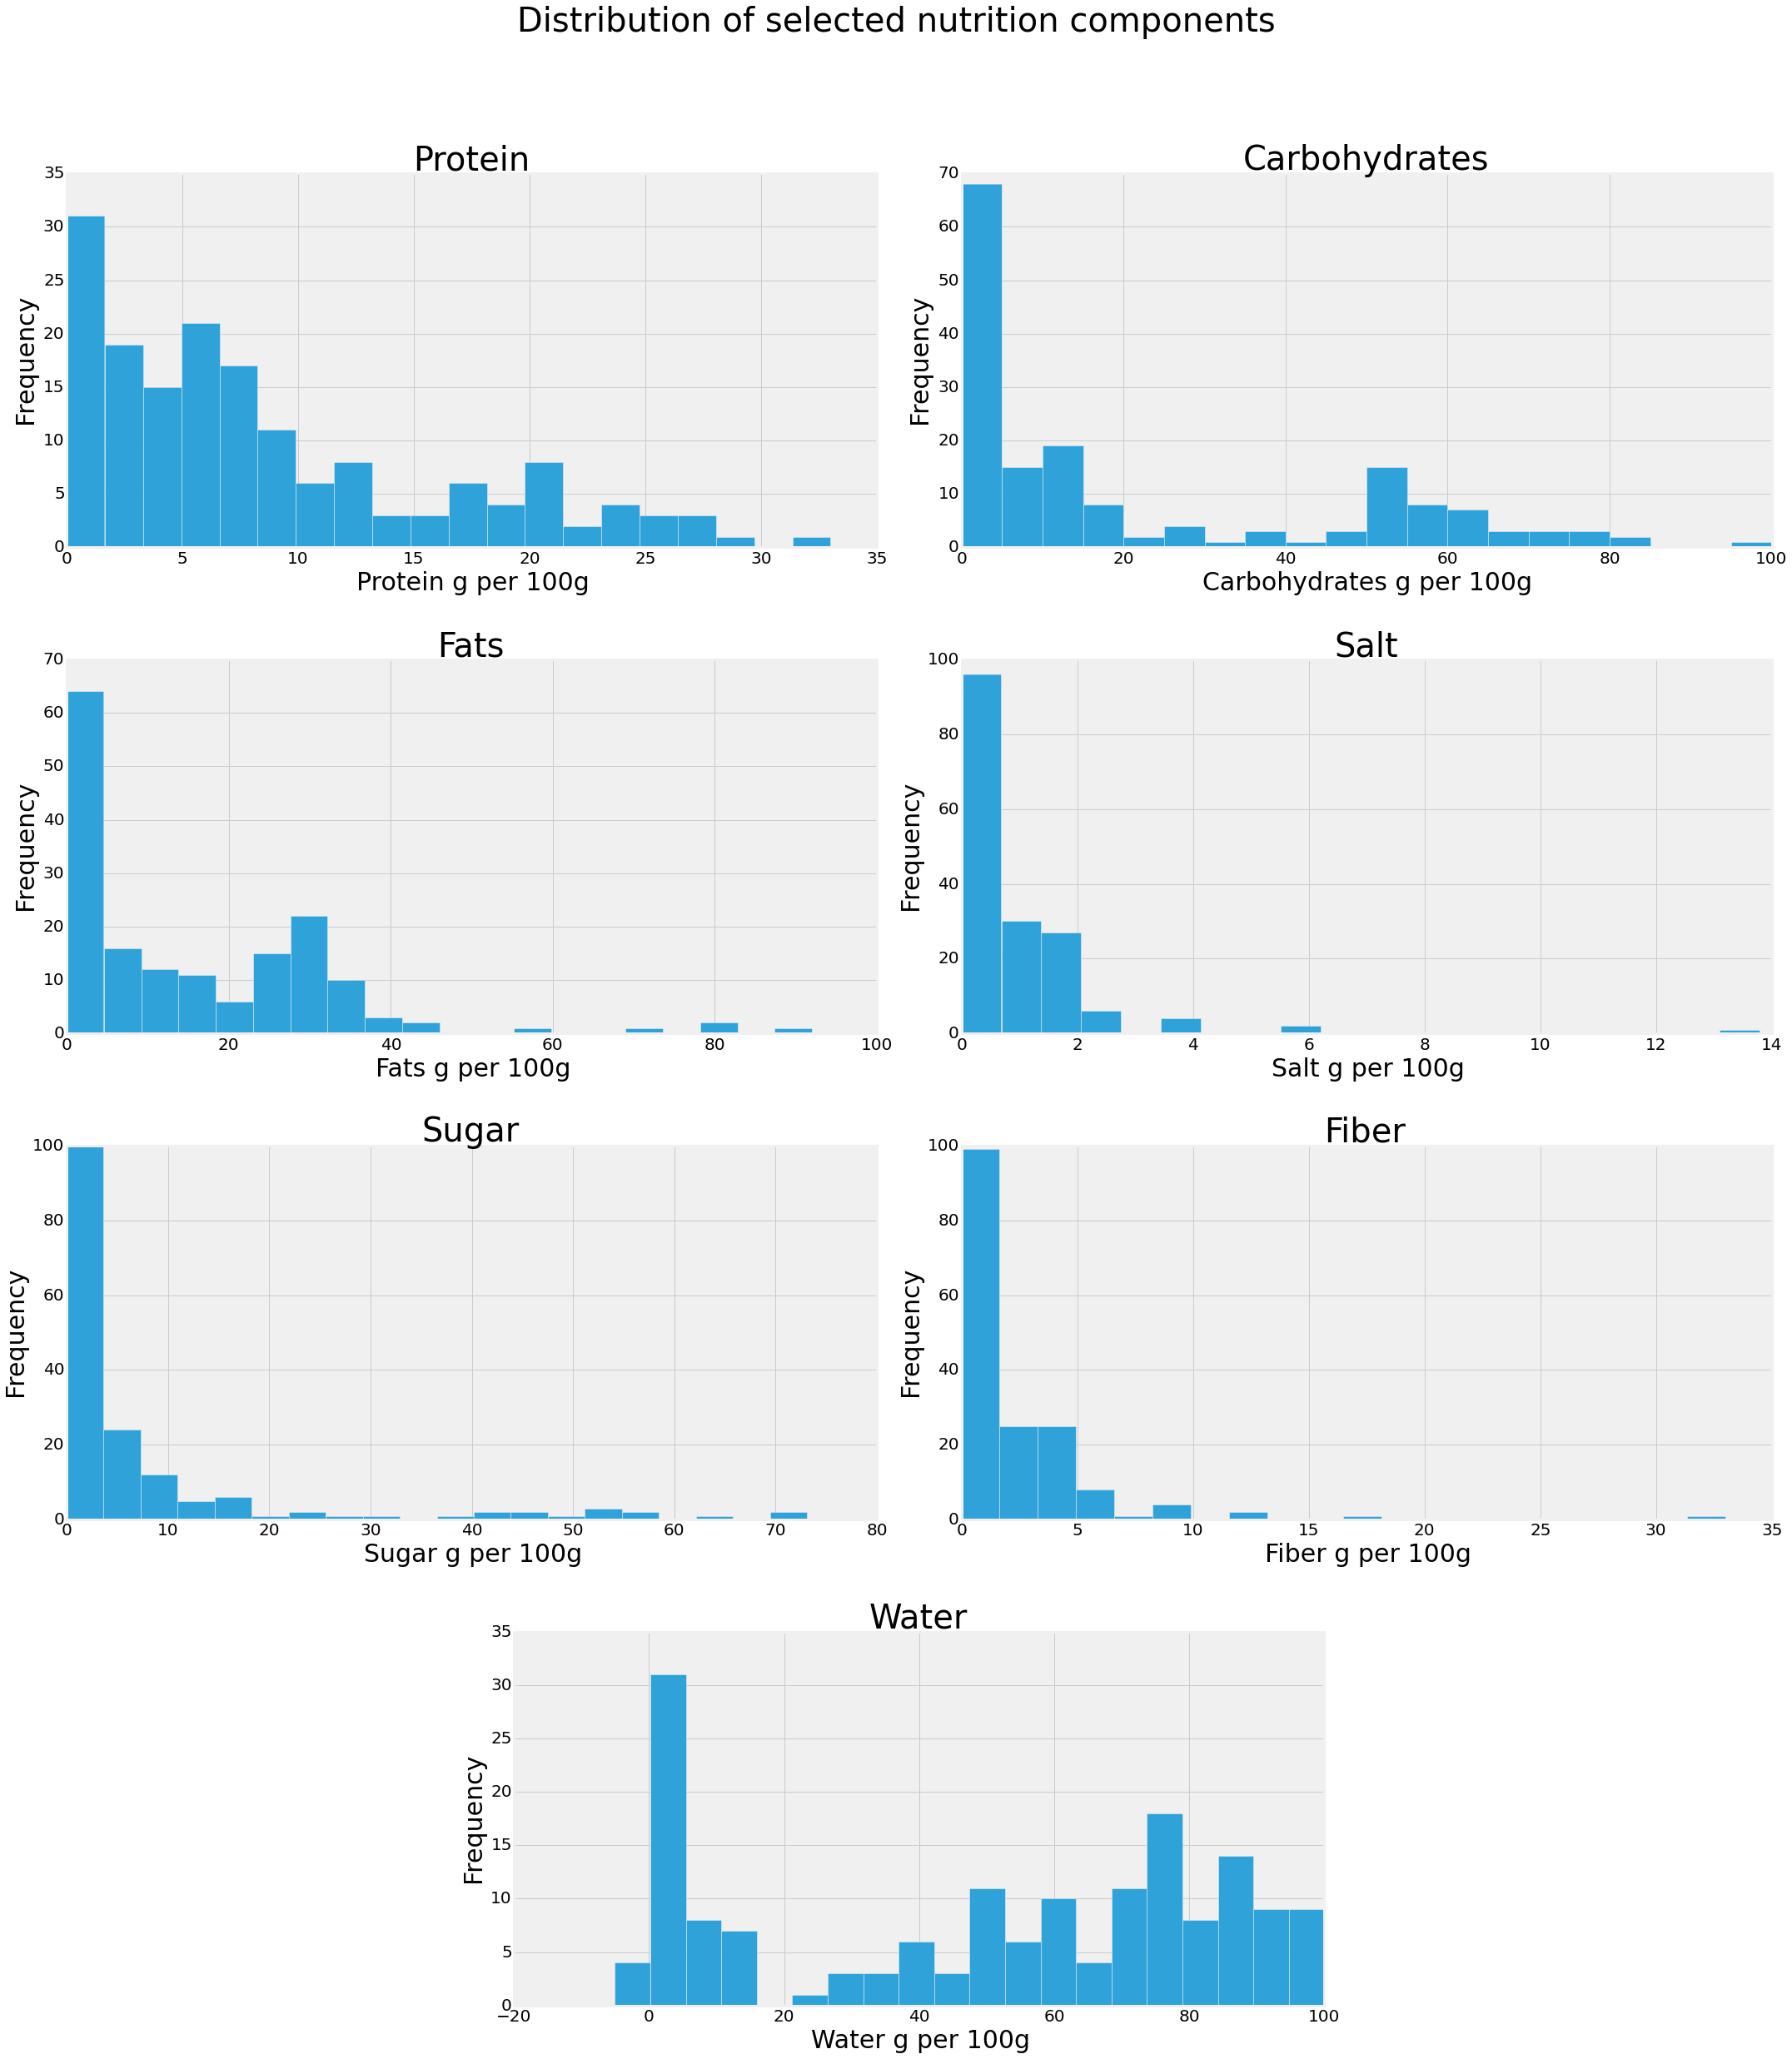

In [5]:
fig = plt.figure(figsize = (30,35))
fig.suptitle("Distribution of selected nutrition components", fontsize = 40)

gs = gridspec.GridSpec(4,4)
bin_no = 20

ax0 = plt.subplot(gs[0,0:2])
ax1 = plt.subplot(gs[0,2:4])
ax2 = plt.subplot(gs[1,0:2])
ax3 = plt.subplot(gs[1,2:4])
ax4 = plt.subplot(gs[2,0:2])
ax5 = plt.subplot(gs[2,2:4])
ax6 = plt.subplot(gs[3,1:3])

ax_list = [ax0,ax1,ax2,ax3,ax4,ax5,ax6]
nut_list = ["Protein","Carbohydrates","Fats","Salt","Sugar", "Fiber", "Water"]

df.proteins_100g.hist(ax = ax0, bins = bin_no, xlabelsize = 20, ylabelsize = 20)
df.carbohydrates_100g.hist(ax = ax1, bins = bin_no, xlabelsize = 20, ylabelsize = 20)
df.fat_100g.hist(ax = ax2, bins = bin_no, xlabelsize = 20, ylabelsize = 20)
df.salt_100g.hist(ax = ax3, bins = bin_no, xlabelsize = 20, ylabelsize = 20)
df.sugars_100g.hist(ax = ax4, bins = bin_no, xlabelsize = 20, ylabelsize = 20)
df.fiber_100g.hist(ax = ax5, bins = bin_no, xlabelsize = 20, ylabelsize = 20)
df.water_100g.hist(ax = ax6, bins = bin_no, xlabelsize = 20, ylabelsize = 20)

for i in range(7):
    ax_list[i].set_ylabel("Frequency", fontsize = 30)
    ax_list[i].set_xlabel(nut_list[i]+" g per 100g", fontsize = 30)
    ax_list[i].set_title(nut_list[i], fontsize = 40)
    
fig.tight_layout()
fig.subplots_adjust(top=0.9, hspace=0.3)

In each case the categories exhibit a reverse J distribution with food items not containing any of one or more types of nutrient (e.g. oil which only contains fats). Water shows an increase higher quantities as any drink will have a high proportion of water, additionally some data show negative amounts of water due to inaccurate recording of other nutrient types (i.e. the sum of the components is greater than 100g).

## Unsupervised Clustering
Clustering analysis involves grouping objects together in which their properties/features are more similar to one another than to members of another group.


Two methods of clustering are used here: agglomerative and k means.<br>

<br>



### Agglomerative Clustering

Agglomerative clustering is a type of hierarchical clustering method which works on the basis of each data point representing its own cluster which then merges with the nearest cluster to form a new cluster. This is repeated until the desired number of clusters is reached.
<br>

<figure>
  <img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Hierarchical_clustering_simple_diagram.svg", vspace="40">
</figure>



### K Means Clustering

K means clustering assigns each data point to the nearest cluster centre (clusters can be initialised via a number of ways). Once each data point is assigned, a new cluster centre is calculated (based on the average position of all data within the cluster). The data are then reassigned to the nearest new cluster centre and the process is repeated until convergence is reached.

<figure>
  <img src="https://upload.wikimedia.org/wikipedia/commons/7/7c/K-means_convergence_to_a_local_minimum.png", vspace="40">
</figure>


In [6]:
#Create an array from selected columns
food_array = df.ix[:,5:12].values

cluster_no = 5

agglom = AgglomerativeClustering(n_clusters = cluster_no)
agglom.fit(food_array)
df["agglom_labels"] = agglom.labels_

k_means = KMeans(n_clusters = cluster_no, random_state = 1)
k_means.fit(food_array)
df["k_means_labels"] = k_means.labels_

Two dictionaries are created storing a wordcloud object for each method. These are then used to produce wordcloud plots of product names for each cluster for each method. The size of the word relates to the frequency and thus gives a general sense of the food products included in each cluster.

In [7]:
#Create a label for the plots showing the average nutrition values for each cluster rounded to 1dp
agglom_averages = {}
for i in range(cluster_no):
    agglom_averages["agglom{0}".format(i)] = [("Protein: "+ str((df.proteins_100g[df.agglom_labels == i]).mean().round(1))), 
                                              ("Carbs: "+ str((df.carbohydrates_100g[df.agglom_labels == i]).mean().round(1))), 
                                              ("Fat: "+ str((df.fat_100g[df.agglom_labels == i]).mean().round(1))), 
                                              ("Sugar: "+ str((df.sugars_100g[df.agglom_labels == i]).mean().round(1))), 
                                              ("Salt: "+ str((df.salt_100g[df.agglom_labels == i]).mean().round(1))),
                                              ("Fiber: "+ str((df.salt_100g[df.agglom_labels == i]).mean().round(1))),
                                              ("Water: "+ str((df.salt_100g[df.agglom_labels == i]).mean().round(1)))]

k_means_averages = {}
for i in range(cluster_no):
    k_means_averages["k_means{0}".format(i)] = [("Protein: "+ str((df.proteins_100g[df.k_means_labels == i]).mean().round(1))), 
                                                ("Carbs: "+ str((df.carbohydrates_100g[df.k_means_labels == i]).mean().round(1))), 
                                                ("Fat: "+ str((df.fat_100g[df.k_means_labels == i]).mean().round(1))), 
                                                ("Sugar: "+ str((df.sugars_100g[df.k_means_labels == i]).mean().round(1))), 
                                                ("Salt: "+ str((df.salt_100g[df.k_means_labels == i]).mean().round(1))),
                                                ("Fiber: "+ str((df.salt_100g[df.k_means_labels == i]).mean().round(1))),
                                                ("Water: "+ str((df.salt_100g[df.k_means_labels == i]).mean().round(1)))]

Words being sent to be plotted are first filtered to remove non useful data. This is done with the stopwords function which takes a list of stopwords (stop_list) as an argument.

The plots for each method are then shown side by side for the number of clusters that had been specified (5).

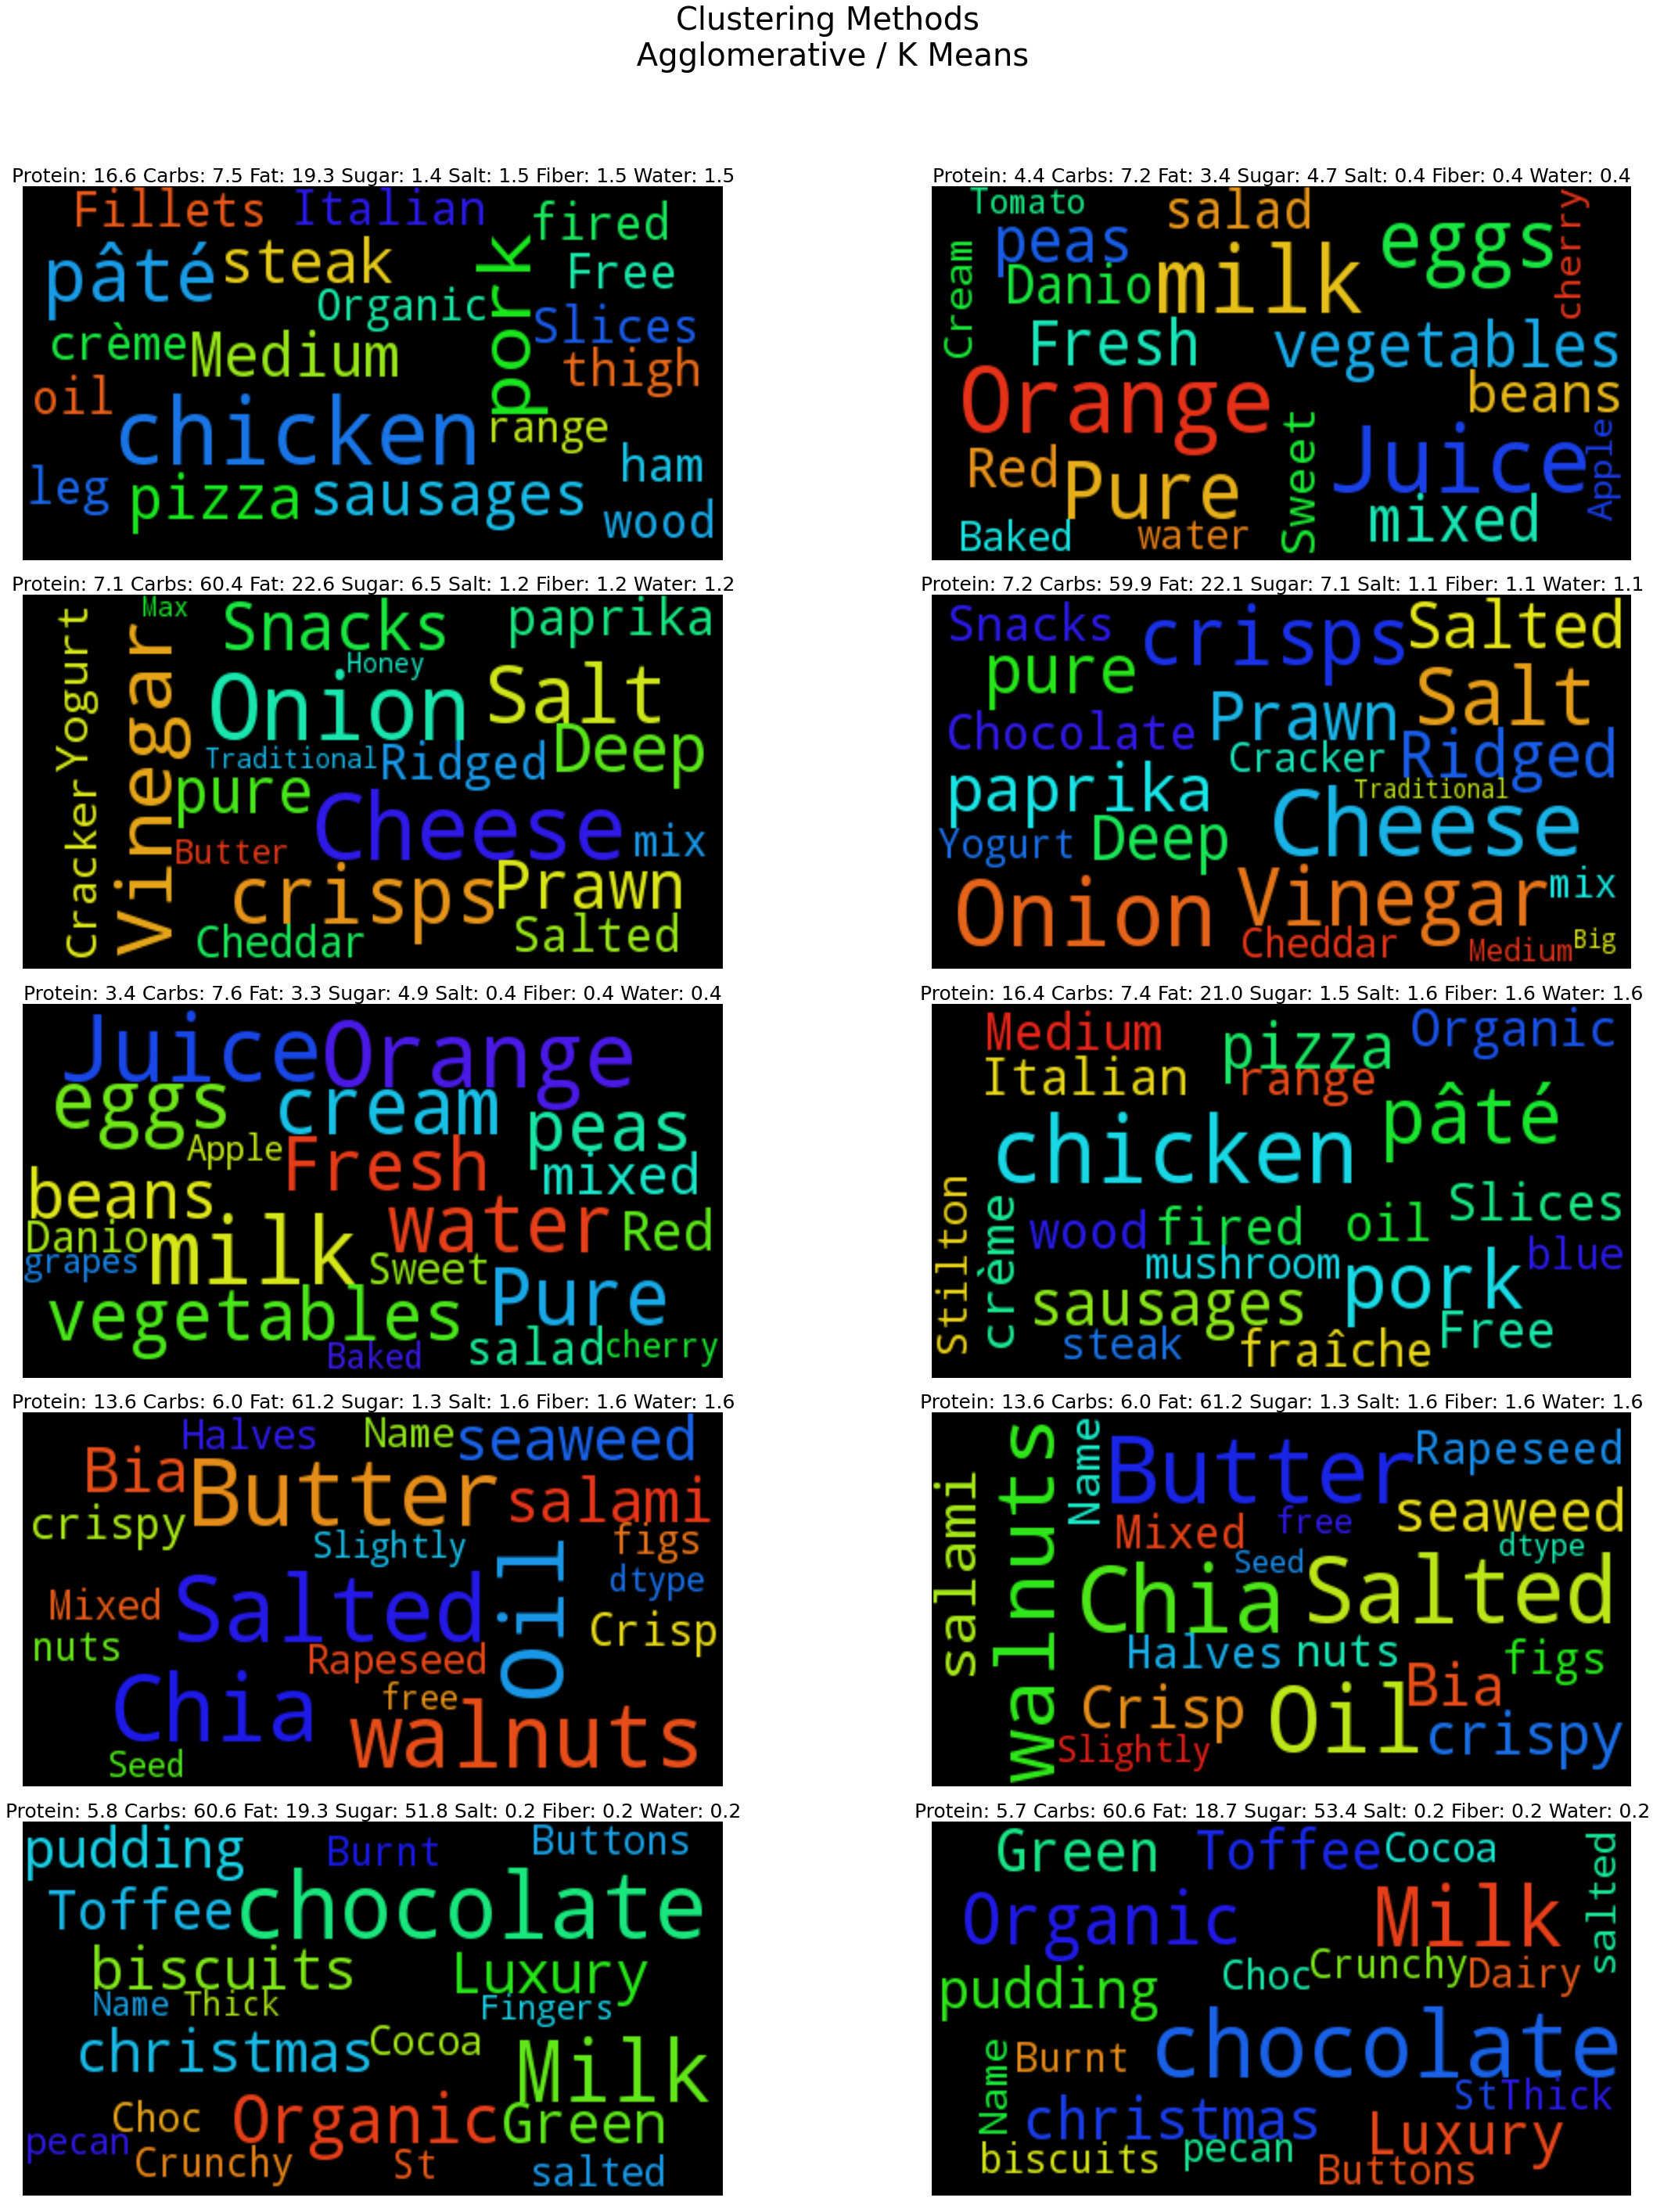

In [8]:
#Filter to remove words from wordcloud that are not useful descriptors
stop_list = ["british", "sainsbury's", "scottish", "100g", "intensely", "original", "dtype", 
             "product_name", "name", "object", "babies", "black's"]

def stopwords(stop_list, string):
    split_string = string.split()
    result_list = [word for word in split_string if word.lower() not in stop_list]
    result = ' '.join(result_list)
    return result


#Set word count for wordcloud plots
word_count = 20

#Make wordclouds for each clustering method based on a string of all product names that have the same cluster label
agglom_clusters = {}
for i in range(0, cluster_no):
    agglom_clusters["agglom{0}".format(i)] = \
    WordCloud(max_font_size=50, relative_scaling = 0.5, max_words = word_count) \
    .generate(stopwords(stop_list, str(df.product_name[df.agglom_labels == i])))
    
k_means_clusters = {}
for i in range(0, cluster_no):
    k_means_clusters["k_means{0}".format(i)] = \
    WordCloud(max_font_size=50, relative_scaling = 0.5, max_words= word_count) \
    .generate(stopwords(stop_list, str(df.product_name[df.k_means_labels == i])))
    
    
#Plot wordclouds for each cluster from each method
f, axarr = plt.subplots(nrows = cluster_no, ncols = 2,  figsize = (cluster_no*6,cluster_no*8))
f.suptitle("Clustering Methods \n Agglomerative / K Means", fontsize = 40)

for i in range(0, cluster_no):
    axarr[i, 0].imshow(agglom_clusters["agglom"+str(i)], aspect = "auto", interpolation=None)
    axarr[i, 0].axis("off")
    axarr[i, 0].set_title(" ".join(agglom_averages["agglom"+str(i)]),fontsize = 25)
    
    axarr[i, 1].imshow(k_means_clusters["k_means"+str(i)], aspect = "auto", interpolation=None)
    axarr[i, 1].axis("off")
    axarr[i, 1].set_title(" ".join(k_means_averages["k_means"+str(i)]),fontsize = 25)
    
plt.tight_layout()
plt.subplots_adjust(top=0.90, wspace = 0.3)

Plots show the most common words found in the product names for each cluster with the larger sized font relating to a higher frequency of the word. Values shown above the plot indicate the average protein, carb, fat, sugar, and salt breakdown per cluster (measured in g per 100g). As the cluster order is randomly generated so the left and right hand plots won’t necessarily be directly comparable. However based on the average composition it is clear that both methods are producing very similar results.

### Issues:
 - Word filter is not removing some non useful data when included in the stop list (dtype etc).

### To Do (20/03/16):
 - Expand on methodology
 - Expand on explanation of cluster methods
 - Include 2D cross plot for feature selection
 - Improve characterisation of resulting clusters
     - Show nutrition distribution of clusters
     - What can be said about the resulting groups?
 - Principle component analysis
 - Address rows with negative water values